# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

Authors: Christina Maher & Alexandra Fink-Skular \
Updated: 06/14/2024 by CMM

In [ ]:
import numpy as np
import pandas as pd
import mne
from glob import glob
from scipy.stats import zscore, t, linregress, ttest_ind, ttest_rel, ttest_1samp 
import os 
import re
import h5io
import pickle 
import time 
import datetime 
from joblib import Parallel, delayed
import statsmodels.api as sm 
from scipy.ndimage import label 
import statsmodels.formula.api as smf
import tqdm
import operator




import warnings
warnings.filterwarnings('ignore')


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/'

In [ ]:
# load helper functions 
import sys
sys.path.append(base_dir)
from cluster_utils_V2 import *
from helper_utils import *
from TFR_Cluster_Test import *

In [ ]:
data_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
tfr_dir  = f'{data_dir}ephys_analysis/data/'
beh_dir  = f'{data_dir}behavior_analysis/behavior_preprocessed/'
anat_dir = f'{data_dir}anat_recons/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

06112024


# Step 1: Format Input Data (Currently within-subject)
- neural input: np.array (n_channels x n_epochs x n_freqs x n_times)
- regressor data: np.array (numpy array: n_epochs x n_features)

In [ ]:
# # Set directory path for epoched data + set subj_id(s) for analysis
# epochs_path = f'{base_dir}test_data/'
# subj_id     = 'MS002' #if loading multiple subjects make list & load epochs into dict
# # set directory for results 
# results_dir = f'{base_dir}results/'

In [ ]:
# load epoched data for single subj
subj_id     = 'MS002'
power_epochs = mne.time_frequency.read_tfrs(fname=f'{tfr_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]


Reading /Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/MS002/MS002_CpeOnset-tfr.h5 ...
Adding metadata with 19 columns


In [ ]:
# set ROI for single ROI anaylsis 
roi = 'ains'
# set all variables included mutliple regression 
multi_reg_vars = ['GambleChoice','TotalProfit','RPE','decisionCPE']
# set main variable of interest for permutations 
permute_var = 'decisionCPE'

In [ ]:
# load ROI info for all elecs/subj 
roi_info_df  = pd.read_csv(f'{anat_dir}roi_reref_labels_master.csv')
# find subj_ids for subjects with electrodes in ROI 
roi_subj_ids   = roi_info_df.subj_id[roi_info_df.roi == roi].unique().tolist()
roi_subj_elecs = {f'{subj_id}':roi_info_df.reref_ch_names[roi_info_df.subj_id == subj_id].unique().tolist() for subj_id in roi_subj_ids}

In [ ]:
# prepare regressor dataframe: 
# dataframe: shape = n_roi_elecs/subj_id x num covariates
            # all categorical variables should be data type 'pd.category'
            # all continuous variables should be data type 'float64' and zscored *within subject*

roi_subj_beh_df = []

for subj_id in roi_subj_ids: 
    # load subj behavior data 
    beh_df = pd.read_csv(f'{beh_dir}{subj_id}_task_data')
    # clean subj dataframe from fail trials/nan values in vars of interest 
    # beh_df[~(beh_df.GambleChoice=='gamble')|~(beh_df.GambleChoice=='safe')] = np.nan
    # beh_df = beh_df[~beh_df.Outcome.isnull()]
    beh_df['GambleChoice'][(beh_df.GambleChoice!='gamble')&(beh_df.GambleChoice!='safe')&(~beh_df.GambleChoice.isnull())] = np.nan
    # beh_df = beh_df[(beh_df.GambleChoice=='gamble')|(beh_df.GambleChoice=='safe')]
    # beh_df = beh_df[~beh_df.Outcome.isnull()]
    # set datatypes for categorical vars
    beh_df['GambleChoice'] = beh_df['GambleChoice'].astype('category')
    beh_df['subj_id'] = subj_id
    beh_df[multi_reg_vars[1:]] = pd.DataFrame({f'{var}':zscore(beh_df[var])  for var in multi_reg_vars[1:]})
    # beh_df = beh_df[['subj_id','Round'] + multi_reg_vars]
    beh_df = beh_df[['subj_id','Round'] + multi_reg_vars]    
    roi_subj_beh_df.append(beh_df)

roi_subj_beh_df = pd.concat(roi_subj_beh_df).reset_index(drop=True)
roi_subj_beh_df['GambleChoice'] = roi_subj_beh_df['GambleChoice'].astype('category')


In [ ]:
roi_subj_beh_df

,subj_id,Round,GambleChoice,TotalProfit,RPE,decisionCPE
0,MS002,1,safe,-1.995065,-0.017258,-0.800927
1,MS002,2,gamble,-2.612713,-1.110240,-0.899141
2,MS002,3,gamble,-1.520452,1.915595,1.470249
3,MS002,4,safe,-1.520452,-0.017258,0.880971
4,MS002,5,gamble,-0.714260,1.409371,0.807311
...,...,...,...,...,...,...
1947,MS050,146,gamble,1.260120,-2.101641,-1.635286
1948,MS050,147,safe,1.260120,-0.004218,0.377167
1949,MS050,148,gamble,1.260120,-0.489572,-0.503281
1950,MS050,149,safe,1.220379,-0.004218,0.125611


## Run Univariate Regression 
- Use TFRClusterTest class code to run univariate regression
- Allows for multiple regression implementation and pixel paralellization, so with more speed improvements will ultimately be worth it. (ONGOING DEV)

In [ ]:
#### class TFR_Cluster_Test dev + debugging

# subset single electrode tfr data + behav data
tfr_data = np.squeeze(power_epochs._data[:,16,:,:].copy())
predictor_data = roi_subj_beh_df[roi_subj_beh_df.subj_id == 'MS002'].drop(columns=['subj_id','Round'])

test_univar = predictor_data[permute_var].copy()

In [ ]:
uni_test = TFR_Cluster_Test(tfr_data,pd.DataFrame(test_univar),permute_var)
uni_betas, uni_tstats = uni_test.tfr_multireg()
uni_cluster_data = uni_test.max_tfr_cluster(uni_tstats)

uni_cluster_data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

pixel regression time:  38.57


[{'clust_stat': 726.5527156843962, 'freq_idx': (11, 12), 'time_idx': (32, 60)},
 {'clust_stat': -1067.262107856609,
  'freq_idx': (4, 6),
  'time_idx': (607, 616)}]

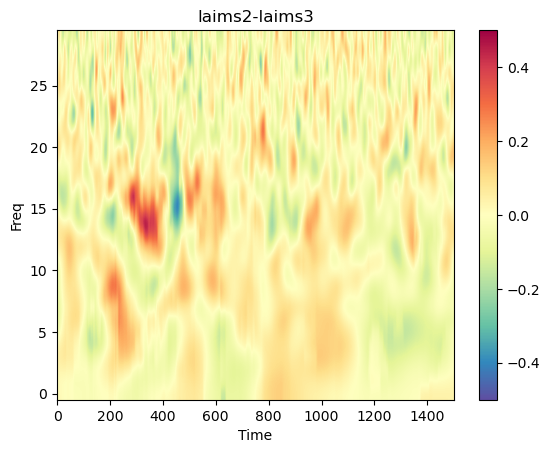

In [ ]:
plt.imshow(uni_betas, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
plt.colorbar()
plt.ylabel('Freq')
plt.xlabel('Time')
plt.title(f'{power_epochs.ch_names[16]}')
plt.show()

## Run Multiple Regression 
- Using TFRClusterTest class
- Need to implement the permutation version of this code (ONGOING DEV)
- Need to add more functionality + plotting utils (ONGOING DEV)

In [ ]:
predictor_data

,GambleChoice,TotalProfit,RPE,decisionCPE
0,safe,-1.995065,-0.017258,-0.800927
1,gamble,-2.612713,-1.110240,-0.899141
2,gamble,-1.520452,1.915595,1.470249
3,safe,-1.520452,-0.017258,0.880971
4,gamble,-0.714260,1.409371,0.807311
...,...,...,...,...
145,gamble,2.146421,1.409371,0.512672
146,safe,2.146421,-0.017258,-0.297586
147,gamble,1.236205,-1.627968,-1.206056
148,gamble,1.236205,-0.983684,-0.469458


In [ ]:
elec_test = TFR_Cluster_Test(tfr_data,predictor_data,permute_var)
elec_betas, elec_tstats = elec_test.tfr_multireg()
elec_cluster_data = elec_test.max_tfr_cluster(elec_tstats)

elec_cluster_data

In [ ]:
multi_test = TFR_Cluster_Test(tfr_data,predictor_data,permute_var)
multi_betas, multi_tstats = multi_test.tfr_multireg()
multi_cluster_data = multi_test.max_tfr_cluster(multi_tstats)

multi_cluster_data

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1826s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 tas

pixel regression time:  58.11


[{'clust_stat': 445.61076562387507,
  'freq_idx': (15, 17),
  'time_idx': (280, 306)},
 {'clust_stat': -952.5101241246377,
  'freq_idx': (10, 13),
  'time_idx': (1249, 1309)}]

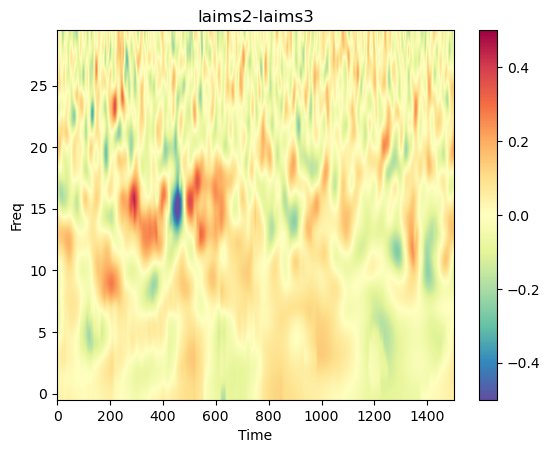

In [ ]:
plt.imshow(multi_betas, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Freq')
plt.title(f'{power_epochs.ch_names[16]}')
plt.show()

# Step 3: Extract Surrogate Clusters from Pixel-wise Permutation *PREVIOUS VERSION - CHRISTINA WILL UPDATE*
- For loop for each electrode- 
- Run each permutation (1000x) in parallel within electrode loop
- Calculate max cluster p value for each +/- cluster for each electrode
- Save permuted cluster statistics for each electrode 

DEPENDENCIES: permuted_tfr_cluster_test, tfr_cluster_test

In [ ]:
### TEST PERMUTATIONS 
num_permutations = 1000
start = time.time() # start timer

all_ch_perm = {}

for c in range(num_channels):
        ch_start = time.time() # start timer

        # Prepare arguments for the permutation function
        permutation_args = [
        (np.squeeze(power_epochs._data[:,c,:,:]), reg_data, tcritical)
        for _ in range(num_permutations)]
    
        # Perform permutations in parallel
        elec_permuted_data = Parallel(n_jobs=-1, verbose=12)(
        delayed(permuted_tfr_cluster_test)(*args)
        for args in permutation_args)
        
        # save in all elec dict 
        all_ch_perm[ch_names[c]] = elec_permuted_data
        pickle.dump(elec_permuted_data, open(f'{results_dir}{subj_id}_{ch_names[c]}_perm_clusters.pkl', "wb")) 

        ch_end = time.time() 
        print(f'{ch_names[c]} permute time: ', '{:.2f}'.format(ch_end-ch_start))
        
        

end = time.time()    
print('{:.2f} s'.format(end-start)) # print time elapsed for computation (approx 4 seconds per permutation)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

lacas1-lacas2 permute time:  2222.30


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

KeyboardInterrupt: 

In [ ]:
num_permutations = 1000
ch_start = time.time() # start timer

# Prepare arguments for the permutation function
permutation_args = [
(np.squeeze(power_epochs._data[:,c,:,:]), reg_data, tcritical)
for _ in range(num_permutations)]

# Perform permutations in parallel
elec_permuted_data_reduc = Parallel(n_jobs=-1, verbose=12)(
delayed(permuted_tfr_cluster_test)(*args)
for args in permutation_args)

# save in all elec dict 
# all_ch_perm[ch_names[c]] = elec_permuted_data
pickle.dump(elec_permuted_data_reduc, open(f'{results_dir}{subj_id}_{ch_names[c]}_reduced_output_perm_clusters.pkl', "wb")) 

ch_end = time.time() 
print(f'{ch_names[c]} permute time: ', '{:.2f}'.format(ch_end-ch_start))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

laims2-laims3 permute time:  2178.48


In [ ]:
elec_permuted_data

{'results_betas': array([[ 0.07496082,  0.07568205,  0.07640095, ..., -0.0100412 ,
         -0.00988225, -0.00972245],
        [ 0.11049633,  0.11199644,  0.11349419, ...,  0.01570515,
          0.01619038,  0.01668231],
        [ 0.15378925,  0.15533521,  0.15687356, ...,  0.04369581,
          0.0441821 ,  0.04468103],
        ...,
        [ 0.13442341,  0.14565859,  0.15230832, ..., -0.02047693,
          0.02107548,  0.06610168],
        [ 0.07638172,  0.10577456,  0.12961218, ..., -0.08342112,
         -0.05628506, -0.04392064],
        [-0.01453783, -0.02366936, -0.03528101, ..., -0.1266133 ,
         -0.10745436, -0.09402729]]),
 'tstat_observed': array([[ 0.77350381,  0.78096577,  0.78837237, ..., -0.10668448,
         -0.1048461 , -0.1030016 ],
        [ 1.04259185,  1.05652562,  1.07038852, ...,  0.17455808,
          0.17978833,  0.1850744 ],
        [ 1.52371944,  1.53667189,  1.54944371, ...,  0.46651023,
          0.4716797 ,  0.47696856],
        ...,
        [ 1.4442022

In [ ]:
elec_permuted_data_reduc

[(298.09901001049246, 136.65549636093147),
 (416.62770479299354, 294.02828639583845),
 (213.59620000754634, 161.3735007138127),
 (776.4162480069654, 346.0772862745674),
 (699.5711094275869, 291.25891852679166),
 (263.43614340489853, 482.1334299376421),
 (321.7094325851797, 814.2876139906707),
 (1046.84402514575, 2333.8754487420783),
 (503.92539785009524, 318.03396552392513),
 (3267.6333142172816, 306.45038172574954),
 (1071.8413092866156, 450.88592825587494),
 (342.4957075736979, 541.4328474638614),
 (884.0766553697839, 692.284183355802),
 (1137.2591985985878, 433.34819297661335),
 (660.0653655560752, 619.1936027582708),
 (656.5377522142544, 301.4506391071268),
 (707.5103430220606, 158.99476310451865),
 (532.8078319548499, 148.69888641633457),
 (342.15703060688145, 459.0734808127743),
 (334.6597627149725, 424.63972204863467),
 (103.05975358418993, 1339.9864464398865),
 (446.6581833826948, 242.67833451315664),
 (538.7768915190258, 557.3786981854928),
 (352.86551793200977, 1739.855157561